In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay,accuracy_score,f1_score,classification_report
from sklearn.model_selection import train_test_split
from custom_dataloader import replicate_data, replicate_data_single

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PRF import prf
from copulas.multivariate import GaussianMultivariate
# Using py39 env


# Compare RF and PRF with c2d

## Input Data

1. Obtain training data from c2d (with NAN values implicit in data)
2. Cut data to only data with all bands
3. Cut data to only data with at least one band missing
4. Make four sets of data:
    * All bands available
    * 90% of data in all bands available
    * 80% of data in all bands available
    * 70% of data in all bands available


In [2]:
file_inp = "c2d_w_quality.csv"
input_df = pd.read_csv(file_inp)
bands = [idx for idx in input_df.columns.values if (idx[0].lower() == 'm'.lower() or idx[0].lower() == 'e'.lower())]


# Fill with NANs for non-detections
for i, b in enumerate(bands):
    if i%2 == 0:
        ind = input_df[(input_df['q_'+b] == 'U') | (input_df['q_'+b] == 'N')].index
        input_df.loc[ind, b] = np.nan
        input_df.loc[ind, bands[i+1]] = np.nan

# Remove MIPS2
bands = bands[:-2]

input_df


,Unnamed: 0,RAJ2000,DEJ2000,alpha,Target,mag_J,e_mag_J,q_mag_J,mag_H,e_mag_H,...,q_mag_IR3,mag_IR4,e_mag_IR4,q_mag_IR4,mag_MP1,e_mag_MP1,q_mag_MP1,mag_MP2,e_mag_MP2,q_mag_MP2
0,2,277.212616,0.859071,-2.32,2,16.474261,0.142999,B,15.025750,0.079259,...,B,NaN,NaN,U,NaN,NaN,U,NaN,NaN,N
1,4,277.212616,0.665340,-2.28,2,15.895028,0.086983,A,14.273175,0.045601,...,A,13.282227,0.155610,B,NaN,NaN,U,NaN,NaN,U
2,9,277.126923,0.464996,-2.74,2,NaN,NaN,N,NaN,NaN,...,C,NaN,NaN,U,NaN,NaN,U,NaN,NaN,U
3,16,277.120972,0.430608,-2.16,2,NaN,NaN,U,15.025750,0.083602,...,A,13.814679,0.254108,C,NaN,NaN,U,NaN,NaN,U
4,19,277.126404,0.792648,-2.48,2,14.606632,0.036981,A,13.520600,0.038001,...,A,12.481236,0.091324,A,NaN,NaN,U,NaN,NaN,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786246,6634891,67.516670,18.230413,-0.92,0,8.622263,0.022979,A,7.960563,0.017988,...,A,5.954320,0.053872,A,1.927282,0.100498,A,NaN,NaN,U
786247,6634892,75.777412,25.388849,-1.00,0,9.911106,0.021966,A,9.075222,0.028953,...,A,6.749147,0.056355,A,3.920352,0.100135,A,NaN,NaN,U
786248,6634893,252.190079,-14.276626,-0.97,0,8.718302,0.024058,A,7.573470,0.038006,...,A,4.489270,0.060629,A,1.874736,0.100879,A,NaN,NaN,U
786249,6634894,67.714104,24.706188,-1.21,0,9.494137,0.020988,A,8.693864,0.028974,...,A,6.848329,0.054948,A,4.454541,0.100293,A,NaN,NaN,U


In [3]:
# Separate data with bands with NANs from data with no nans
ind_nan =  [2]
for i, b in enumerate(bands):
    if i%2 == 0:
        # print(input_df[(input_df['q_'+b] == 'U') | (input_df['q_'+b] == 'N')].index)
        ind_nan = np.r_[ind_nan,input_df[(input_df['q_'+b] == 'U') | (input_df['q_'+b] == 'N')].index.values]

input_nan = input_df[np.r_[bands,['Target']]].loc[np.unique(ind_nan)]
input_nonan = input_df[np.r_[bands,['Target']]].dropna(subset=bands)


In [5]:
# Split data into 100% data with all bands, data with 90% missing, 80%, 70%

inp_100, tar_100 = replicate_data_single(input_nonan[bands].values.astype(float),input_nonan['Target'].values.astype(int),[3000,500,6500])

inp_90, tar_90 = replicate_data_single(input_nonan[bands].values.astype(float),input_nonan['Target'].values.astype(int),[2700,450,5850])
inp_90_na, tar_90_na =replicate_data_single(input_nan[bands].values.astype(float),input_nan['Target'].values.astype(int),[300,50,650])
inp_90, tar_90 = np.r_[inp_90,inp_90_na], np.r_[tar_90,tar_90_na]

inp_80, tar_80 = replicate_data_single(input_nonan[bands].values.astype(float),input_nonan['Target'].values.astype(int),[2400,400,5200])
inp_80_na, tar_80_na =replicate_data_single(input_nan[bands].values.astype(float),input_nan['Target'].values.astype(int),[600,100,1300])
inp_80, tar_80 = np.r_[inp_80,inp_80_na], np.r_[tar_80,tar_80_na]

inp_70, tar_70 = replicate_data_single(input_nonan[bands].values.astype(float),input_nonan['Target'].values.astype(int),[2150,350,4550])
inp_70_na, tar_70_na =replicate_data_single(input_nan[bands].values.astype(float),input_nan['Target'].values.astype(int),[850,150,1950])
inp_70, tar_70 = np.r_[inp_70,inp_70_na], np.r_[tar_70,tar_70_na]

inp_60, tar_60 = replicate_data_single(input_nonan[bands].values.astype(float),input_nonan['Target'].values.astype(int),[int(3000*.6),int(450*.6),int(6500*.6)])
inp_60_na, tar_60_na =replicate_data_single(input_nan[bands].values.astype(float),input_nan['Target'].values.astype(int),[850,int(450*.4),int(6500*.4)])
inp_60, tar_60 = np.r_[inp_60,inp_60_na], np.r_[tar_60,tar_60_na]

inp_50, tar_50 = replicate_data_single(input_nonan[bands].values.astype(float),input_nonan['Target'].values.astype(int),[int(3000*.5),int(450*.5),int(6500*.5)])
inp_50_na, tar_50_na =replicate_data_single(input_nan[bands].values.astype(float),input_nan['Target'].values.astype(int),[850,int(450*.5),int(6500*.5)])
inp_50, tar_50 = np.r_[inp_50,inp_50_na], np.r_[tar_50,tar_50_na]


## Copulas and thermal noise

In [17]:
# Thermal noise values
def fill_therm(inputs):
    inds = np.array([0,2,4,6,8,10,12,14])
    noise = [max(inputs[i])+5 for i in inds]
    error = [max(inputs[i+1]) for i in inds]

    inp_th = np.empty((16,len(inputs)))
    for i, inp in enumerate(inputs.transpose()):
        if i%2 == 0:
            inp_th[i] = np.array(inp)
            inp_th[i+1] = np.array(inputs.transpose()[i+1])
            inp_th[i][np.where(np.isnan(inp))[0]] = noise[int(i/2)]
            inp_th[i+1][np.where(np.isnan(inp))[0]] = error[int(i/2)]

    return np.array(inp_th).transpose()  

inp_90_therm = np.array(fill_therm(inp_90))
inp_80_therm = fill_therm(inp_80)
inp_70_therm = fill_therm(inp_70)
inp_60_therm = fill_therm(inp_60)
inp_50_therm = fill_therm(inp_50)

In [18]:
# Copulas values
import warnings

warnings.filterwarnings('ignore')

copula = GaussianMultivariate()
copula.fit(inp_100)
# synth1000 = copula.sample(10000)

def fill_copula(inputs,cop):
    inp_cop = np.empty((16,len(inputs)))
    for i, inp in enumerate(inputs.transpose()):
        if i%2 == 0:
            inp_cop[i] = np.array(inp)
            inp_cop[i+1] = np.array(inputs.transpose()[i+1])
            inp_cop[i][np.where(np.isnan(inp))[0]] = cop.sample(len(np.where(np.isnan(inp))[0])).values[:,i]
            inp_cop[i+1][np.where(np.isnan(inp))[0]] = cop.sample(len(np.where(np.isnan(inp))[0])).values[:,i+1]
    
    return np.array(inp_cop).transpose()

inp_90_cop = fill_copula(inp_90,copula)
inp_80_cop = fill_copula(inp_80,copula)
inp_70_cop = fill_copula(inp_70,copula)
inp_60_cop = fill_copula(inp_60,copula)
inp_50_cop = fill_copula(inp_50,copula)
    

## RF and PRF fits

In [19]:
# RF fitting
rf_100 = RandomForestClassifier()

rf_90_th = RandomForestClassifier()
rf_80_th = RandomForestClassifier()
rf_70_th = RandomForestClassifier()
rf_60_th = RandomForestClassifier()
rf_50_th = RandomForestClassifier()

rf_90_c = RandomForestClassifier()
rf_80_c = RandomForestClassifier()
rf_70_c = RandomForestClassifier()
rf_60_c = RandomForestClassifier()
rf_50_c = RandomForestClassifier()


inp_100, inp_100_va, tar_100, tar_100_va = train_test_split(inp_100,tar_100)

rf_100.fit(inp_100,tar_100.ravel())


inp_90_therm, inp_90_therm_va, tar_90_therm, tar_90_therm_va = train_test_split(inp_90_therm,tar_90)
inp_80_therm, inp_80_therm_va, tar_80_therm, tar_80_therm_va = train_test_split(inp_80_therm,tar_80)
inp_70_therm, inp_70_therm_va, tar_70_therm, tar_70_therm_va = train_test_split(inp_70_therm,tar_70)
inp_60_therm, inp_60_therm_va, tar_60_therm, tar_60_therm_va = train_test_split(inp_60_therm,tar_60)
inp_50_therm, inp_50_therm_va, tar_50_therm, tar_50_therm_va = train_test_split(inp_50_therm,tar_50)

rf_90_th.fit(inp_90_therm,tar_90_therm.ravel())
rf_80_th.fit(inp_80_therm,tar_80_therm.ravel())
rf_70_th.fit(inp_70_therm,tar_70_therm.ravel())
rf_60_th.fit(inp_60_therm,tar_60_therm.ravel())
rf_50_th.fit(inp_50_therm,tar_50_therm.ravel())


inp_90_cop, inp_90_cop_va, tar_90_cop, tar_90_cop_va = train_test_split(inp_90_cop,tar_90)
inp_80_cop, inp_80_cop_va, tar_80_cop, tar_80_cop_va = train_test_split(inp_80_cop,tar_80)
inp_70_cop, inp_70_cop_va, tar_70_cop, tar_70_cop_va = train_test_split(inp_70_cop,tar_70)
inp_60_cop, inp_60_cop_va, tar_60_cop, tar_60_cop_va = train_test_split(inp_60_cop,tar_60)
inp_50_cop, inp_50_cop_va, tar_50_cop, tar_50_cop_va = train_test_split(inp_50_cop,tar_50)

rf_90_c.fit(inp_90_cop,tar_90_cop.ravel())
rf_80_c.fit(inp_80_cop,tar_80_cop.ravel())
rf_70_c.fit(inp_70_cop,tar_70_cop.ravel())
rf_60_c.fit(inp_60_cop,tar_60_cop.ravel())
rf_50_c.fit(inp_50_cop,tar_50_cop.ravel())

pred_rf_100 = rf_100.predict(inp_100)
pred_rf_100_va = rf_100.predict(inp_100_va)

pred_rf_90_th = rf_90_th.predict(inp_90_therm)
pred_rf_80_th = rf_80_th.predict(inp_80_therm)
pred_rf_70_th = rf_70_th.predict(inp_70_therm)
pred_rf_60_th = rf_60_th.predict(inp_60_therm)
pred_rf_50_th = rf_50_th.predict(inp_50_therm)

pred_rf_90_c = rf_90_c.predict(inp_90_cop)
pred_rf_80_c = rf_80_c.predict(inp_80_cop)
pred_rf_70_c = rf_70_c.predict(inp_70_cop)
pred_rf_60_c = rf_60_c.predict(inp_60_cop)
pred_rf_50_c = rf_50_c.predict(inp_50_cop)




In [20]:


pred_rf_100_va = rf_100.predict(inp_100_va)

pred_rf_90_th_va = rf_90_th.predict(inp_90_therm_va)
pred_rf_80_th_va = rf_80_th.predict(inp_80_therm_va)
pred_rf_70_th_va = rf_70_th.predict(inp_70_therm_va)
pred_rf_60_th_va = rf_60_th.predict(inp_60_therm_va)
pred_rf_50_th_va = rf_50_th.predict(inp_50_therm_va)

pred_rf_90_c_va = rf_90_c.predict(inp_90_cop_va)
pred_rf_80_c_va = rf_80_c.predict(inp_80_cop_va)
pred_rf_70_c_va = rf_70_c.predict(inp_70_cop_va)
pred_rf_60_c_va = rf_60_c.predict(inp_60_cop_va)
pred_rf_50_c_va = rf_50_c.predict(inp_50_cop_va)

In [21]:
# PRF fitting
prf_100 = prf(n_estimators=100, bootstrap=False)
prf_90 = prf(n_estimators=100, bootstrap=False)
prf_80 = prf(n_estimators=100, bootstrap=False)
prf_70 = prf(n_estimators=100, bootstrap=False)
prf_60 = prf(n_estimators=100, bootstrap=False)
prf_50 = prf(n_estimators=100, bootstrap=False)


inp_90, inp_90_va, tar_90, tar_90_va = train_test_split(inp_90,tar_90)
inp_80, inp_80_va, tar_80, tar_80_va = train_test_split(inp_80,tar_80)
inp_70, inp_70_va, tar_70, tar_70_va = train_test_split(inp_70,tar_70)
inp_60, inp_60_va, tar_60, tar_60_va = train_test_split(inp_60,tar_60)
inp_50, inp_50_va, tar_50, tar_50_va = train_test_split(inp_50,tar_50)


inds = np.array([0,2,4,6,8,10,12,14])
prf_100.fit(X=np.array(inp_100)[:,inds],dX=np.array(inp_100)[:,inds+1],y=tar_100)
prf_90.fit(inp_90[:,inds],inp_90[:,inds+1],tar_90)
prf_80.fit(inp_80[:,inds],inp_80[:,inds+1],tar_80)
prf_70.fit(inp_70[:,inds],inp_70[:,inds+1],tar_70)
prf_60.fit(inp_60[:,inds],inp_60[:,inds+1],tar_60)
prf_50.fit(inp_50[:,inds],inp_50[:,inds+1],tar_50)


pred_prf_100 = prf_100.predict(X=np.array(inp_100)[:,inds],dX=np.array(inp_100)[:,inds+1])
pred_prf_90 = prf_90.predict(inp_90[:,inds],inp_90[:,inds+1])
pred_prf_80 = prf_80.predict(inp_80[:,inds],inp_80[:,inds+1])
pred_prf_70 = prf_70.predict(inp_70[:,inds],inp_70[:,inds+1])
pred_prf_60 = prf_60.predict(inp_60[:,inds],inp_60[:,inds+1])
pred_prf_50 = prf_50.predict(inp_50[:,inds],inp_50[:,inds+1])


pred_prf_100_va = prf_100.predict(X=np.array(inp_100_va)[:,inds],dX=np.array(inp_100_va)[:,inds+1])
pred_prf_90_va = prf_90.predict(inp_90_va[:,inds],inp_90_va[:,inds+1])
pred_prf_80_va = prf_80.predict(inp_80_va[:,inds],inp_80_va[:,inds+1])
pred_prf_70_va = prf_70.predict(inp_70_va[:,inds],inp_70_va[:,inds+1])
pred_prf_60_va = prf_60.predict(inp_60_va[:,inds],inp_60_va[:,inds+1])
pred_prf_50_va = prf_50.predict(inp_50_va[:,inds],inp_50_va[:,inds+1])



## Make figure

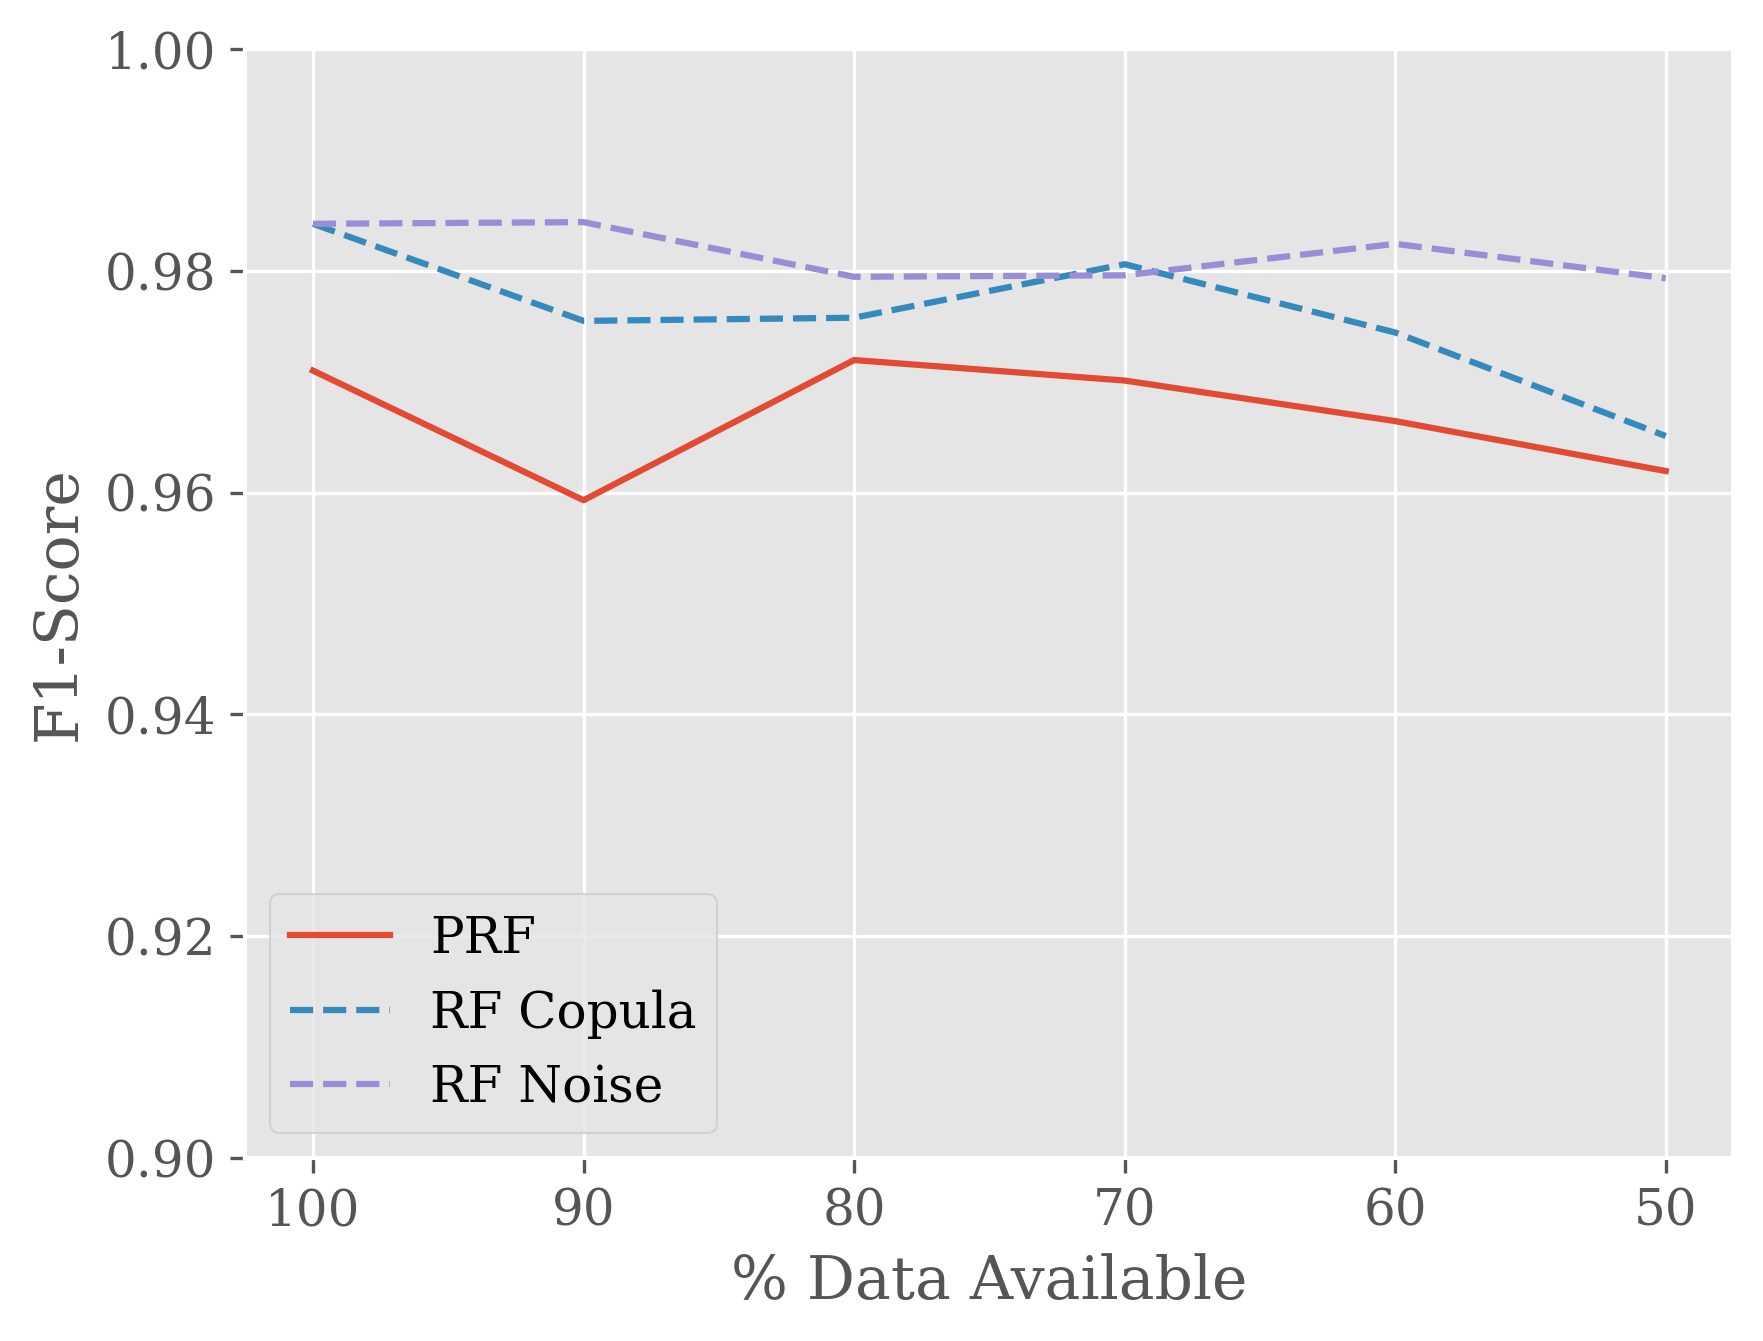

In [35]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'

acc_rf_th = [f1_score(tar_100,pred_rf_100,average=None)[0],f1_score(tar_90,pred_rf_90_th,average=None)[0],f1_score(tar_80,pred_rf_80_th,average=None)[0],f1_score(tar_70,pred_rf_70_th,average=None)[0],f1_score(tar_60,pred_rf_60_th,average=None)[0],f1_score(tar_50,pred_rf_50_th,average=None)[0]]
acc_rf_c = [f1_score(tar_100,pred_rf_100,average=None)[0],f1_score(tar_90,pred_rf_90_c,average=None)[0],f1_score(tar_80,pred_rf_80_c,average=None)[0],f1_score(tar_70,pred_rf_70_c,average=None)[0],f1_score(tar_60,pred_rf_60_c,average=None)[0],f1_score(tar_50,pred_rf_50_c,average=None)[0]]
acc_prf = [f1_score(tar_100,pred_prf_100,average=None)[0],f1_score(tar_90,pred_prf_90,average=None)[0],f1_score(tar_80,pred_prf_80,average=None)[0],f1_score(tar_70,pred_prf_70,average=None)[0],f1_score(tar_60,pred_prf_60,average=None)[0],f1_score(tar_50,pred_prf_50,average=None)[0]]


acc_rf_th_va = [f1_score(tar_100_va,pred_rf_100_va,average=None)[0],f1_score(tar_90_therm_va,pred_rf_90_th_va,average=None)[0],f1_score(tar_80_therm_va,pred_rf_80_th_va,average=None)[0],f1_score(tar_70_therm_va,pred_rf_70_th_va,average=None)[0],f1_score(tar_60_therm_va,pred_rf_60_th_va,average=None)[0],f1_score(tar_50_therm_va,pred_rf_50_th_va,average=None)[0]]
acc_rf_c_va = [f1_score(tar_100_va,pred_rf_100_va,average=None)[0],f1_score(tar_90_cop_va,pred_rf_90_c_va,average=None)[0],f1_score(tar_80_cop_va,pred_rf_80_c_va,average=None)[0],f1_score(tar_70_cop_va,pred_rf_70_c_va,average=None)[0],f1_score(tar_60_cop_va,pred_rf_60_c_va,average=None)[0],f1_score(tar_50_cop_va,pred_rf_50_c_va,average=None)[0]]
acc_prf_va = [f1_score(tar_100_va,pred_prf_100_va,average=None)[0],f1_score(tar_90_va,pred_prf_90_va,average=None)[0],f1_score(tar_80_va,pred_prf_80_va,average=None)[0],f1_score(tar_70_va,pred_prf_70_va,average=None)[0],f1_score(tar_60_va,pred_prf_60_va,average=None)[0],f1_score(tar_50_va,pred_prf_50_va,average=None)[0]]


# acc_rf_th = [accuracy_score(tar_100,pred_rf_100),accuracy_score(tar_90,pred_rf_90_th),accuracy_score(tar_80,pred_rf_80_th),accuracy_score(tar_70,pred_rf_70_th),accuracy_score(tar_60,pred_rf_60_th),accuracy_score(tar_50,pred_rf_50_th)]
# acc_rf_c = [accuracy_score(tar_100,pred_rf_100),accuracy_score(tar_90,pred_rf_90_c),accuracy_score(tar_80,pred_rf_80_c),accuracy_score(tar_70,pred_rf_70_c),accuracy_score(tar_60,pred_rf_60_c),accuracy_score(tar_50,pred_rf_50_c)]
# acc_prf = [accuracy_score(tar_100,pred_prf_100),accuracy_score(tar_90,pred_prf_90),accuracy_score(tar_80,pred_prf_80),accuracy_score(tar_70,pred_prf_70),accuracy_score(tar_60,pred_prf_60),accuracy_score(tar_50,pred_prf_50)]


# acc_rf_th_va = [accuracy_score(tar_100_va,pred_rf_100_va),accuracy_score(tar_90_therm_va,pred_rf_90_th_va),accuracy_score(tar_80_therm_va,pred_rf_80_th_va),accuracy_score(tar_70_therm_va,pred_rf_70_th_va),accuracy_score(tar_60_therm_va,pred_rf_60_th_va),accuracy_score(tar_50_therm_va,pred_rf_50_th_va)]
# acc_rf_c_va = [accuracy_score(tar_100_va,pred_rf_100_va),accuracy_score(tar_90_cop_va,pred_rf_90_c_va),accuracy_score(tar_80_cop_va,pred_rf_80_c_va),accuracy_score(tar_70_cop_va,pred_rf_70_c_va),accuracy_score(tar_60_cop_va,pred_rf_60_c_va),accuracy_score(tar_50_cop_va,pred_rf_50_c_va)]
# acc_prf_va = [accuracy_score(tar_100_va,pred_prf_100_va),accuracy_score(tar_90_va,pred_prf_90_va),accuracy_score(tar_80_va,pred_prf_80_va),accuracy_score(tar_70_va,pred_prf_70_va),accuracy_score(tar_60_va,pred_prf_60_va),accuracy_score(tar_50_va,pred_prf_50_va)]

fig, ax = plt.subplots(dpi=300)
plt.plot([100,90,80,70,60,50], acc_prf_va, label='PRF')
plt.plot([100,90,80,70,60,50], acc_rf_c_va, '--', label='RF Copula')
plt.plot([100,90,80,70,60,50], acc_rf_th_va, '--', label='RF Noise')

plt.xlabel('% Data Available')
plt.ylabel('F1-Score')
ax.invert_xaxis()
ax.set_ylim(0.9,1.)
plt.legend()

plt.savefig('PRFvsRF.png',dpi=300)

In [29]:
f1_score(tar_100_va,pred_prf_100_va,average=None)[0]

0.9709944751381215